# Google Colab Upload File

In [ ]:
from google.colab import files
uploaded = files.upload()

#Note : google colab was used to do this project

Saving 3A.zip to 3A (3).zip


In [ ]:
!ls

 3A  '3A (1).zip'  '3A (2).zip'  '3A (3).zip'   3A_split   3A.zip   sample_data


In [ ]:
import zipfile

with zipfile.ZipFile("3A.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
!ls /content

 3A  '3A (1).zip'  '3A (2).zip'  '3A (3).zip'   3A_split   3A.zip   sample_data


In [ ]:
!ls /content/3A/Train/

'Bacterial diseases - Aeromoniasis'  'Healthy Fish'
'Bacterial gill disease'	     'Parasitic diseases'
'Bacterial Red disease'		     'Viral diseases White tail disease'
'Fungal diseases Saprolegniasis'


In [ ]:
data_dir = "/content/3A/Train/"

# Import Library

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import numpy as np

from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0,DenseNet121,MobileNetV2,EfficientNetV2S
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from collections import Counter
from sklearn.model_selection import train_test_split
import shutil

SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
import random
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [ ]:
def create_model(model_name):
    return ModelCheckpoint(
        model_save_dir + model_name + ".h5",
        verbose=1,
        monitor='val_loss',
        save_best_only=True
    )

def create_csv_logger(model_name):
    return CSVLogger(log_save_dir+'{}-log.csv'.format(model_name), append=True, separator=',')

class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_v_loss = np.inf
        self.best_loss = np.inf

    def on_epoch_end(self, epoch, logs=None):
        v_loss=logs.get('val_loss')
        loss=logs.get('loss')

        # If BOTH the validation loss AND map10 does not improve for 'patience' epochs, stop training early.
        if np.less(v_loss, self.best_v_loss) and np.less(loss, self.best_loss):
            self.best_v_loss = v_loss
            self.best_loss = loss
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
            self.model.save(model_save_dir+model_name[0:10]+".h5",include_optimizer=False)

        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                self.model.save(model_save_dir+model_name[0:10]+".h5",include_optimizer=False)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
        print("Restoring model weights from the end of the best epoch.")
        self.model.set_weights(self.best_weights)

class TimedStopping(tf.keras.callbacks.Callback):
    '''Stop training when enough time has passed.
    # Arguments
        seconds: maximum time before stopping.
        verbose: verbosity mode.
    '''
    def __init__(self, seconds=None, verbose=0):
        super(tf.keras.callbacks.Callback, self).__init__()

        self.start_time = 0
        self.seconds = seconds
        self.verbose = verbose

    def on_train_begin(self, logs={}):
        self.start_time = time.time()

    def on_batch_end(self, epoch, logs={}):
        if time.time() - self.start_time > self.seconds:
            self.model.stop_training = True
            if self.verbose:
                print('Stopping after %s seconds.' % self.seconds)

# EDA + Read Dataset + Preprocessing Image

In [ ]:
classes = os.listdir(data_dir)
print("Jumlah kelas:", len(classes))
print()
for c in classes:
    print(c, ":", len(os.listdir(os.path.join(data_dir, c))))


Jumlah kelas: 7

Parasitic diseases : 226
Healthy Fish : 250
Fungal diseases Saprolegniasis : 238
Bacterial gill disease : 250
Bacterial diseases - Aeromoniasis : 6
Bacterial Red disease : 250
Viral diseases White tail disease : 250


Imbalance dataset on bacterial diseases - Aeromoniasi

Solution : Add more data


Since we cannot have a new data, let's try to do oversampling instead
(will be done when train splitting)

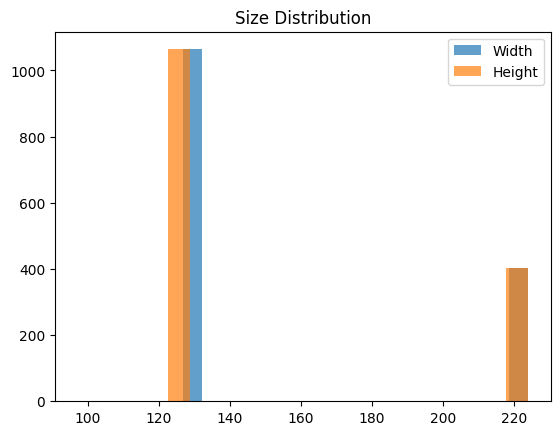

In [ ]:
import cv2

sizes = []

for c in classes:
    for img_name in os.listdir(os.path.join(data_dir, c)):
        img_path = os.path.join(data_dir, c, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            h, w, _ = img.shape
            sizes.append((w, h))

widths, heights = zip(*sizes)
plt.hist(widths, bins=20, alpha=0.7, label='Width')
plt.hist(heights, bins=20, alpha=0.7, label='Height')
plt.legend()
plt.title("Size Distribution")
plt.show()

Solution : Resize image data into (224, 224)

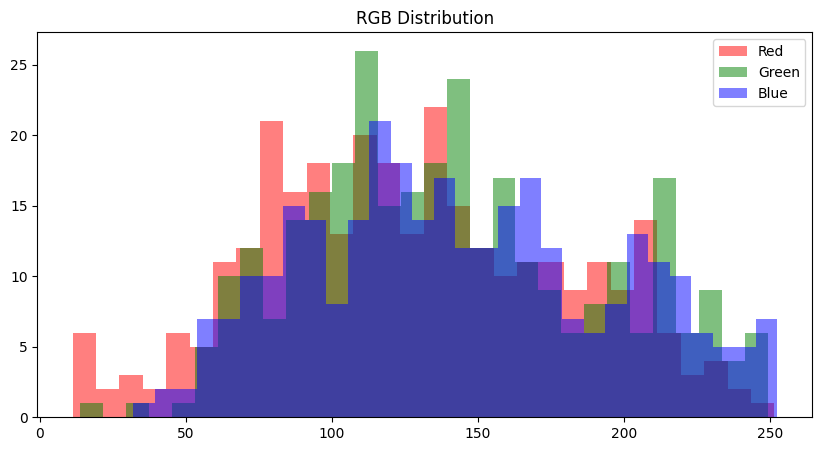

In [ ]:
means = []
for c in classes:
    for img_name in os.listdir(os.path.join(data_dir, c))[:50]:
        img = cv2.imread(os.path.join(data_dir, c, img_name))
        if img is not None:
            means.append(cv2.mean(img)[:3])

means = np.array(means)
plt.figure(figsize=(10,5))
plt.hist(means[:,0], bins=30, color='r', alpha=0.5, label='Red')
plt.hist(means[:,1], bins=30, color='g', alpha=0.5, label='Green')
plt.hist(means[:,2], bins=30, color='b', alpha=0.5, label='Blue')
plt.legend()
plt.title("RGB Distribution")
plt.show()


- Color red is a bit imbalance, probably because of the bacterial red disease, we can let it slide

- Other, no issue with color distribution, proceed to the next step

In [ ]:
 def copy_files(file_list, subset_name):
    subset_dir = os.path.join(output_dir, subset_name, class_name)
    os.makedirs(subset_dir, exist_ok=True)
    for f in file_list:
      src = os.path.join(class_path, f)
      dst = os.path.join(subset_dir, f)
      shutil.copy(src, dst)

In [ ]:
base_dir = "/content/3A/Train"

output_dir = "/content/3A_split"

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

os.makedirs(output_dir, exist_ok=True)


for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)

    images = [f for f in os.listdir(class_path)]

    train_files, temp_files = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen_train = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_valid = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


#Note : since we dont have data/test and data/train directory, we will try to create datagen_test and datagen_valid from datagen_train splits

In [ ]:
train_it = datagen_train.flow_from_directory(
    "/content/3A_split/train/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
)

valid_it = datagen_valid.flow_from_directory(
    "/content/3A_split/val/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

test_it = datagen_valid.flow_from_directory(
    "/content/3A_split/test/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

Found 1365 images belonging to 7 classes.
Found 294 images belonging to 7 classes.
Found 152 images belonging to 7 classes.


In [ ]:
for image,labels in train_it:
    print(image,labels)
    break

[[[[245.        215.        142.       ]
   [245.        215.        142.       ]
   [245.        215.        142.       ]
   ...
   [165.88954   133.88954    82.88955  ]
   [174.5962    141.22127    92.28368  ]
   [157.5765    123.57651    76.951355 ]]

  [[253.02454   227.03682   154.03682  ]
   [252.92285   226.88428   153.88428  ]
   [252.82117   226.73175   153.73175  ]
   ...
   [166.11035   134.11035    83.11035  ]
   [174.71632   141.32104    92.41397  ]
   [150.78888   116.78889    70.18406  ]]

  [[255.        230.        157.       ]
   [255.        230.        157.       ]
   [255.        230.        157.       ]
   ...
   [167.        135.         84.       ]
   [174.7859    141.37029    92.49371  ]
   [148.27417   114.27417    67.68969  ]]

  ...

  [[245.        221.        147.       ]
   [245.        221.        147.       ]
   [245.        221.        147.       ]
   ...
   [246.63087   217.63087   141.63087  ]
   [248.        219.        143.       ]
   [233.97949   

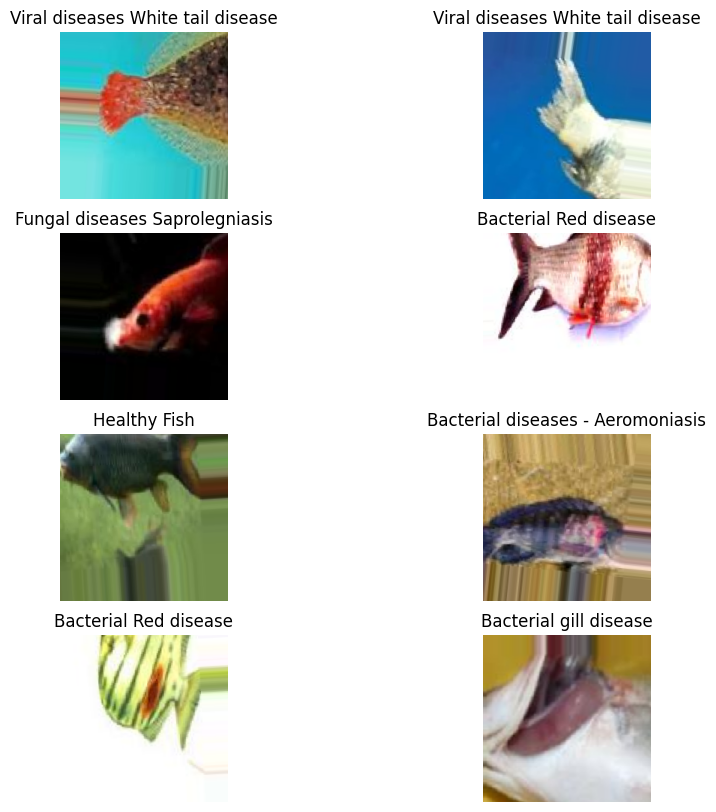

In [ ]:
plt.figure(figsize=(10, 10))

images, labels = next(train_it)

for i in range(8):
    ax = plt.subplot(4, 2, i + 1)
    plt.imshow(images[i].astype("uint8"))
    class_idx = np.argmax(labels[i])
    class_name = list(train_it.class_indices.keys())[class_idx]
    plt.title(class_name)
    plt.axis("off")

plt.show()


Analysis :

- Some classes are very difficult to distinguish due to visual similarity

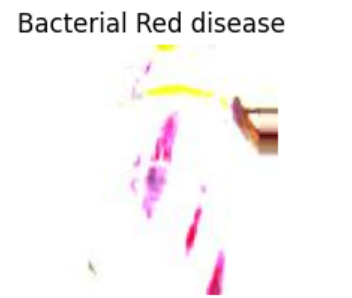

- Some image are noisy, overly bright, or show only a small part of the fish’s body.

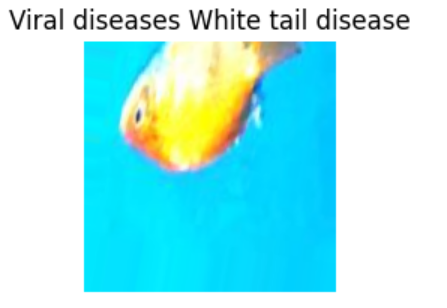

- Some image doesnt even represent the disease.  For example, this images labeled as White Tail Disease do not even show the tail, which is the actual infected part

Solution : Transfer Learning or maybe cleaning data like removing some irrelevant image

In [ ]:
labels = train_it.classes
unique, counts = np.unique(labels, return_counts=True)

for num, amount in zip(unique, counts):
    print(f"Class {num}: {amount} images")

# Dataset is not balanced!

Class 0: 195 images
Class 1: 195 images
Class 2: 195 images
Class 3: 195 images
Class 4: 195 images
Class 5: 195 images
Class 6: 195 images


Solution : Oversampling the classes

In [ ]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

base_dir = "/content/3A_split/train"
target_count = 195

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)

    files = [f for f in os.listdir(class_path)]
    n_files = len(files)

    print(n_files)

    if n_files < target_count:
        print(f"{class_name}: {n_files} -> {target_count}")
        needed = target_count - n_files

        gen_count = 0
        while gen_count < needed:
            file_to_aug = random.choice(files)
            img_path = os.path.join(class_path, file_to_aug)

            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in datagen.flow(
                x,
                batch_size=1,
                save_to_dir=class_path,
                save_prefix='aug',
                save_format='jpg'
            ):
                gen_count += 1
                break


195
195
195
195
195
195
198


In [ ]:
for class_name in sorted(os.listdir(base_dir)):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    n_images = len([
        f for f in os.listdir(class_path)

    ])

    print(f"{class_name}: {n_images} images")


Bacterial Red disease: 195 images
Bacterial diseases - Aeromoniasis: 195 images
Bacterial gill disease: 195 images
Fungal diseases Saprolegniasis: 195 images
Healthy Fish: 195 images
Parasitic diseases: 195 images
Viral diseases White tail disease: 198 images


In [ ]:
labels = valid_it.classes
unique, counts = np.unique(labels, return_counts=True)

for num, amount in zip(unique, counts):
    print(f"Class {num}: {amount} images")

# Validation dataset is not balanced, augmeneted data on validation is not a good idea either

Class 0: 50 images
Class 1: 1 images
Class 2: 50 images
Class 3: 48 images
Class 4: 50 images
Class 5: 45 images
Class 6: 50 images


In [ ]:
labels = test_it.classes
unique, counts = np.unique(labels, return_counts=True)

for num, amount in zip(unique, counts):
    print(f"Class {num}: {amount} images")

# Test dataset is not balanced,augmeneted data on validation is not a good idea either

Class 0: 26 images
Class 1: 1 images
Class 2: 26 images
Class 3: 24 images
Class 4: 26 images
Class 5: 23 images
Class 6: 26 images


Analysis :

- It seems that class 1 or Bacterial diseases - Aeromoniasis do not have enough data than the other

Solution : Oversampling for Class 1

# CNN Model

In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense, GlobalAveragePooling2D, Dropout,BatchNormalization

inputs = tf.keras.layers.Input(shape=(224,224,3))

base_model = Conv2D(filters=96,kernel_size=(11,11),strides=4,activation='relu',padding='same')(inputs)
base_model = MaxPool2D(pool_size=(3,3),strides=2)(base_model)

base_model = Conv2D(filters=256,kernel_size=(5,5),strides=2,activation='relu',padding='same')(base_model)
base_model = MaxPool2D(pool_size=(3,3),strides=2)(base_model)

base_model = Conv2D(filters=384,kernel_size=(3,3),strides=1,activation='relu',padding='same')(base_model)

base_model = Conv2D(filters=256,kernel_size=(3,3),strides=1,activation='relu',padding='same')(base_model)

base_model = MaxPool2D(pool_size=(3,3),strides=2)(base_model)

X = GlobalAveragePooling2D()(base_model)

X = Dense(1024, activation='relu')(X)
X = Dense(1024, activation='relu')(X)
outputs = Dense(7, activation='softmax')(X)
modelSoal = Model(inputs,outputs)
modelSoal.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,739,655 (14.27 MB)

 Trainable params: 3,739,655 (14.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelSoal.compile(
    loss="categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
outputs_dir = "Notebook Outputs/"

import time
now = time.strftime("%m-%d_%H-%M", time.localtime())

model_name = now+"_keras_cnn"
model_save_dir = outputs_dir+model_name+"/models/"
log_save_dir = outputs_dir+model_name+"/logs/"
res_data_dir = outputs_dir+model_name+"/results/"

os.makedirs(outputs_dir,exist_ok=True)
os.makedirs(model_save_dir,exist_ok=True)
os.makedirs(log_save_dir,exist_ok=True)
os.makedirs(res_data_dir,exist_ok=True)

In [ ]:
epochs = 20
callback_fn = [create_model(model_name),create_csv_logger(model_name),CustomEarlyStopping(patience = 5)]

timestamp1 = datetime.now()
hist = modelSoal.fit(train_it, epochs=epochs, validation_data=valid_it, verbose=1,callbacks=callback_fn)
timestamp2 = datetime.now()

print("The training took {} seconds".format((timestamp2 - timestamp1).total_seconds()))

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.1547 - loss: 365.7449

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.96400, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 52s 298ms/step - accuracy: 0.1547 - loss: 364.0810 - val_accuracy: 0.1531 - val_loss: 1.9640
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.1625 - loss: 2.1791
Epoch 2: val_loss improved from 1.96400 to 1.94839, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 299ms/step - accuracy: 0.1624 - loss: 2.1794 - val_accuracy: 0.1327 - val_loss: 1.9484
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.1383 - loss: 2.0718
Epoch 3: val_loss did not improve from 1.94839
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.1384 - loss: 2.0717 - val_accuracy: 0.1190 - val_loss: 1.9583
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.1900 - loss: 2.1816
Epoch 4: val_loss did not improve from 1.94839
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 298ms/step - accuracy: 0.1899 - loss: 2.1816 - val_accuracy: 0.1701 - val_loss: 3.5996
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.1610 - loss: 2.2528
Epoch 5: val_loss improved from 1.94839 to 1.89823, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 299ms/step - accuracy: 0.1611 - loss: 2.2517 - val_accuracy: 0.1769 - val_loss: 1.8982
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.2340 - loss: 1.9670
Epoch 6: val_loss improved from 1.89823 to 1.89479, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 298ms/step - accuracy: 0.2341 - loss: 1.9668 - val_accuracy: 0.1633 - val_loss: 1.8948
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.2613 - loss: 1.8931
Epoch 7: val_loss improved from 1.89479 to 1.87775, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step - accuracy: 0.2614 - loss: 1.8929 - val_accuracy: 0.1973 - val_loss: 1.8777
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.2804 - loss: 1.8108
Epoch 8: val_loss improved from 1.87775 to 1.76798, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 52s 300ms/step - accuracy: 0.2804 - loss: 1.8109 - val_accuracy: 0.2619 - val_loss: 1.7680
Epoch 9/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.3048 - loss: 1.7287
Epoch 9: val_loss did not improve from 1.76798
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.3048 - loss: 1.7288 - val_accuracy: 0.1803 - val_loss: 1.8159
Epoch 10/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.3146 - loss: 1.7793
Epoch 10: val_loss did not improve from 1.76798
171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 313ms/step - accuracy: 0.3145 - loss: 1.7791 - val_accuracy: 0.2551 - val_loss: 1.8764
Epoch 11/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.3249 - loss: 1.7085
Epoch 11: val_loss did not improve from 1.76798
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 298ms/step - accuracy: 0.3249 - loss: 1.7089 - val_accuracy: 0.2109 - val_loss: 1.9392
Epoch 12/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.3382 - loss: 1.6405
Epoch 12: val_loss imp

171/171 ━━━━━━━━━━━━━━━━━━━━ 56s 325ms/step - accuracy: 0.3381 - loss: 1.6406 - val_accuracy: 0.2721 - val_loss: 1.7233
Epoch 13/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.3766 - loss: 1.6483
Epoch 13: val_loss did not improve from 1.72332
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 296ms/step - accuracy: 0.3766 - loss: 1.6485 - val_accuracy: 0.3027 - val_loss: 1.7380
Epoch 14/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4115 - loss: 1.5966
Epoch 14: val_loss did not improve from 1.72332
171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - accuracy: 0.4115 - loss: 1.5966 - val_accuracy: 0.2211 - val_loss: 2.0742
Epoch 15/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.4216 - loss: 1.5448
Epoch 15: val_loss improved from 1.72332 to 1.60129, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 59s 343ms/step - accuracy: 0.4217 - loss: 1.5447 - val_accuracy: 0.4252 - val_loss: 1.6013
Epoch 16/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.3778 - loss: 1.6809
Epoch 16: val_loss did not improve from 1.60129
171/171 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - accuracy: 0.3780 - loss: 1.6803 - val_accuracy: 0.3061 - val_loss: 1.8407
Epoch 17/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.4061 - loss: 1.5721
Epoch 17: val_loss improved from 1.60129 to 1.44642, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 60s 353ms/step - accuracy: 0.4062 - loss: 1.5720 - val_accuracy: 0.4660 - val_loss: 1.4464
Epoch 18/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4699 - loss: 1.5325
Epoch 18: val_loss did not improve from 1.44642
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - accuracy: 0.4698 - loss: 1.5329 - val_accuracy: 0.3810 - val_loss: 1.9814
Epoch 19/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.4569 - loss: 1.4857
Epoch 19: val_loss did not improve from 1.44642


171/171 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - accuracy: 0.4569 - loss: 1.4860 - val_accuracy: 0.4014 - val_loss: 1.5934
Epoch 20/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4248 - loss: 1.6946
Epoch 20: val_loss did not improve from 1.44642
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 318ms/step - accuracy: 0.4249 - loss: 1.6941 - val_accuracy: 0.2653 - val_loss: 2.9267
Restoring model weights from the end of the best epoch.
The training took 1072.367168 seconds


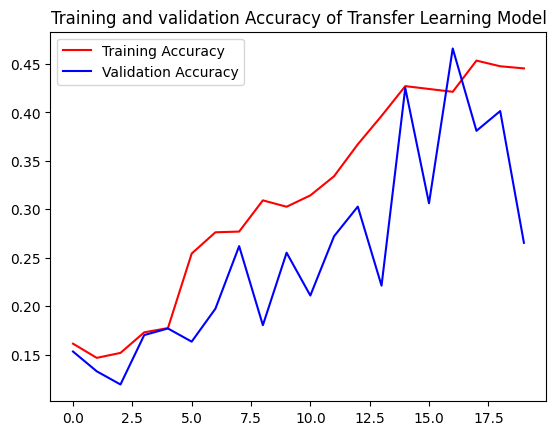

In [ ]:
acc = hist.history['accuracy']
loss = hist.history['loss']
val_accuracy = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
epochs = range(0, len(loss))

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title("Training and validation Loss".format())
plt.legend()
plt.savefig(res_data_dir + "Loss.png".format(model_name), dpi=100)
plt.close()

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b', label="Validation Accuracy")
plt.title("Training and validation Accuracy of First Model".format())
plt.legend()
plt.savefig(res_data_dir + "Accuracy.png".format(model_name), dpi=100)

avg_train_acc = np.mean(acc)
avg_train_loss = np.mean(loss)
avg_val_acc = np.mean(val_accuracy)
avg_val_loss = np.mean(val_loss)

with open(res_data_dir+'Train Results.txt', 'a') as files:
    files.write("Average Train Accuracy : {} \n".format(avg_train_acc))
    files.write("Average Train Loss : {} \n".format(avg_train_loss))
    files.write("Average Validation Accuracy : {} \n".format(avg_val_acc))
    files.write("Average Validation Loss : {} \n".format(avg_val_loss))


# CNN Model Fine Tuned

In [ ]:
inputs = tf.keras.layers.Input(shape=(224,224,3))

base_model = Conv2D(filters=32,kernel_size=(3,3),strides=1,activation='relu',padding='same')(inputs)
base_model = BatchNormalization()(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=2)(base_model)
base_model = Dropout(0.25)(base_model)

base_model = Conv2D(filters=64,kernel_size=(3,3),strides=1,activation='relu',padding='same')(base_model)
base_model = BatchNormalization()(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=2)(base_model)
base_model = Dropout(0.3)(base_model)

base_model = Conv2D(filters=128,kernel_size=(3,3),strides=1,activation='relu',padding='same')(base_model)
base_model = BatchNormalization()(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=2)(base_model)
base_model = Dropout(0.4)(base_model)

X = GlobalAveragePooling2D()(base_model)

X = Dense(32,activation='relu')(X)
X = BatchNormalization()(X)
X = Dropout(0.4)(X)

outputs = Dense(7, activation='softmax')(X)
modelTuned = Model(inputs,outputs)
modelTuned.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,631 (385.28 KB)

 Trainable params: 98,119 (383.28 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
modelTuned.compile(
    loss="categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
epochs = 20
callback_fn = [create_model(model_name),create_csv_logger(model_name),CustomEarlyStopping(patience = 5)]

timestamp1 = datetime.now()
hist = modelTuned.fit(train_it, epochs=epochs, validation_data=valid_it, verbose=1,callbacks=callback_fn)
timestamp2 = datetime.now()

print("The training took {} seconds".format((timestamp2 - timestamp1).total_seconds()))

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.2712 - loss: 2.1367
Epoch 1: val_loss improved from inf to 2.14307, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 164s 946ms/step - accuracy: 0.2714 - loss: 2.1361 - val_accuracy: 0.2177 - val_loss: 2.1431
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3178 - loss: 1.8611
Epoch 2: val_loss improved from 2.14307 to 2.09775, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.3179 - loss: 1.8609 - val_accuracy: 0.2211 - val_loss: 2.0978
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3870 - loss: 1.7617
Epoch 3: val_loss improved from 2.09775 to 2.04672, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.3870 - loss: 1.7612 - val_accuracy: 0.3571 - val_loss: 2.0467
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.4170 - loss: 1.5418
Epoch 4: val_loss improved from 2.04672 to 1.81253, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 169s 989ms/step - accuracy: 0.4169 - loss: 1.5419 - val_accuracy: 0.4082 - val_loss: 1.8125
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.4365 - loss: 1.4976
Epoch 5: val_loss did not improve from 1.81253
171/171 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.4365 - loss: 1.4977 - val_accuracy: 0.3333 - val_loss: 1.8406
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4354 - loss: 1.5372
Epoch 6: val_loss improved from 1.81253 to 1.48098, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.4354 - loss: 1.5371 - val_accuracy: 0.4354 - val_loss: 1.4810
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4575 - loss: 1.4151
Epoch 7: val_loss improved from 1.48098 to 1.45567, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.4576 - loss: 1.4151 - val_accuracy: 0.4218 - val_loss: 1.4557
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4809 - loss: 1.4194
Epoch 8: val_loss did not improve from 1.45567
171/171 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.4808 - loss: 1.4192 - val_accuracy: 0.2993 - val_loss: 1.9475
Epoch 9/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4633 - loss: 1.3983
Epoch 9: val_loss did not improve from 1.45567
171/171 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.4633 - loss: 1.3983 - val_accuracy: 0.3673 - val_loss: 1.8421
Epoch 10/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.5211 - loss: 1.3393
Epoch 10: val_loss did not improve from 1.45567
171/171 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.5210 - loss: 1.3394 - val_accuracy: 0.3844 - val_loss: 1.7000
Epoch 11/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.5096 - loss: 1.2726
Epoch 11: val_loss improved from 1.455

171/171 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.5096 - loss: 1.2727 - val_accuracy: 0.4966 - val_loss: 1.3599
Epoch 12/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.5244 - loss: 1.2725
Epoch 12: val_loss did not improve from 1.35988
171/171 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.5243 - loss: 1.2726 - val_accuracy: 0.4014 - val_loss: 1.4131
Epoch 13/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.5267 - loss: 1.2416
Epoch 13: val_loss did not improve from 1.35988
171/171 ━━━━━━━━━━━━━━━━━━━━ 170s 996ms/step - accuracy: 0.5267 - loss: 1.2417 - val_accuracy: 0.4762 - val_loss: 1.4377
Epoch 14/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.5221 - loss: 1.2655
Epoch 14: val_loss did not improve from 1.35988
171/171 ━━━━━━━━━━━━━━━━━━━━ 171s 996ms/step - accuracy: 0.5221 - loss: 1.2656 - val_accuracy: 0.4184 - val_loss: 1.4502
Epoch 15/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.5576 - loss: 1.2325
Epoch 15: val_loss imp

171/171 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.5576 - loss: 1.2328 - val_accuracy: 0.5544 - val_loss: 1.2477
Epoch 16/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.5342 - loss: 1.2558
Epoch 16: val_loss did not improve from 1.24767
171/171 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.5342 - loss: 1.2558 - val_accuracy: 0.3776 - val_loss: 1.4656
Epoch 17/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.5233 - loss: 1.2681
Epoch 17: val_loss did not improve from 1.24767
171/171 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.5234 - loss: 1.2679 - val_accuracy: 0.4048 - val_loss: 1.5148
Epoch 18/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.5716 - loss: 1.1843
Epoch 18: val_loss did not improve from 1.24767
171/171 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.5715 - loss: 1.1844 - val_accuracy: 0.2517 - val_loss: 2.6928
Epoch 19/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5333 - loss: 1.1835
Epoch 19: val_loss did not impr

Restoring model weights from the end of the best epoch.
171/171 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.5722 - loss: 1.1436 - val_accuracy: 0.4660 - val_loss: 1.4138
Epoch 00020: early stopping
Restoring model weights from the end of the best epoch.
The training took 3626.001459 seconds


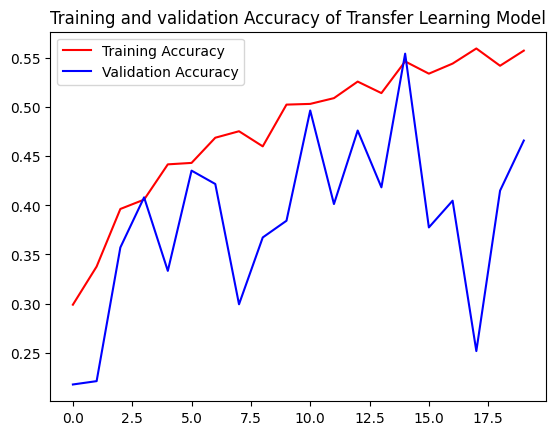

In [ ]:
acc = hist.history['accuracy']
loss = hist.history['loss']
val_accuracy = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
epochs = range(0, len(loss))

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title("Training and validation Loss".format())
plt.legend()
plt.savefig(res_data_dir + "Loss.png".format(model_name), dpi=100)
plt.close()

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b', label="Validation Accuracy")
plt.title("Training and validation Accuracy of Fine Tuned Learning Model".format())
plt.legend()
plt.savefig(res_data_dir + "Accuracy.png".format(model_name), dpi=100)

avg_train_acc = np.mean(acc)
avg_train_loss = np.mean(loss)
avg_val_acc = np.mean(val_accuracy)
avg_val_loss = np.mean(val_loss)

with open(res_data_dir+'Train Results.txt', 'a') as files:
    files.write("Average Train Accuracy : {} \n".format(avg_train_acc))
    files.write("Average Train Loss : {} \n".format(avg_train_loss))
    files.write("Average Validation Accuracy : {} \n".format(avg_val_acc))
    files.write("Average Validation Loss : {} \n".format(avg_val_loss))


After adding batch normalization and fine tuned the architecture of the model, the accuracy went up

# Transfer Learning

In [ ]:
inputs = tf.keras.layers.Input(shape=(224,224,3))

base_model = EfficientNetB0(
    weights='imagenet',
    input_shape=(224,224,3),
    include_top=False
)

base_model.trainable = False

X = base_model(inputs, training=False)

X = layers.GlobalAveragePooling2D()(X)
outputs = layers.Dense(7, activation='softmax')(X)

modelTwo = Model(inputs, outputs)
modelTwo.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
def freeze_weights(model,backbone_name:str,unfrozen_blocks:list):

    layer_names = model.get_layer(backbone_name).layers
    for i in range(len(layer_names)):
        exist_flag = False
        for j in unfrozen_blocks:
            if j not in model.get_layer(backbone_name).layers[i].name and not exist_flag:
                model.get_layer(backbone_name).layers[i].trainable = False
            else:
                model.get_layer(backbone_name).layers[i].trainable = True
                exist_flag = True

    return model

In [ ]:
modelTwo = freeze_weights(modelTwo,backbone_name='efficientnetb0',unfrozen_blocks = ['block6','block7'])

modelTwo.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 2,752,547 (10.50 MB)

 Non-trainable params: 1,305,991 (4.98 MB)

In [ ]:
regularizer = tf.keras.regularizers.l2(0.1)

for layer in modelTwo.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

In [ ]:
opt = SGD(learning_rate=0.01)
modelTwo.compile(
    optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
epochs = 20
callback_fn = [create_model(model_name),create_csv_logger(model_name),CustomEarlyStopping(patience = 5)]

timestamp1 = datetime.now()
hist = modelTwo.fit(train_it, epochs=epochs, validation_data=valid_it, callbacks = callback_fn, verbose=1)
timestamp2 = datetime.now()

print("The training took {} seconds".format((timestamp2 - timestamp1).total_seconds()))

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.4913 - loss: 1.4987
Epoch 1: val_loss improved from inf to 1.03726, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 111s 588ms/step - accuracy: 0.4917 - loss: 1.4976 - val_accuracy: 0.7007 - val_loss: 1.0373
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7452 - loss: 0.8932
Epoch 2: val_loss improved from 1.03726 to 0.75417, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 102s 597ms/step - accuracy: 0.7453 - loss: 0.8928 - val_accuracy: 0.7483 - val_loss: 0.7542
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8073 - loss: 0.6473
Epoch 3: val_loss improved from 0.75417 to 0.62628, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 100s 586ms/step - accuracy: 0.8074 - loss: 0.6471 - val_accuracy: 0.7959 - val_loss: 0.6263
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8712 - loss: 0.4883
Epoch 4: val_loss improved from 0.62628 to 0.49466, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 601ms/step - accuracy: 0.8713 - loss: 0.4882 - val_accuracy: 0.8197 - val_loss: 0.4947
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8710 - loss: 0.4069
Epoch 5: val_loss improved from 0.49466 to 0.41593, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 142s 605ms/step - accuracy: 0.8711 - loss: 0.4068 - val_accuracy: 0.8503 - val_loss: 0.4159
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9057 - loss: 0.3407
Epoch 6: val_loss improved from 0.41593 to 0.37062, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 604ms/step - accuracy: 0.9057 - loss: 0.3406 - val_accuracy: 0.8571 - val_loss: 0.3706
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9127 - loss: 0.2994
Epoch 7: val_loss improved from 0.37062 to 0.35118, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 604ms/step - accuracy: 0.9128 - loss: 0.2992 - val_accuracy: 0.8741 - val_loss: 0.3512
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9410 - loss: 0.2204
Epoch 8: val_loss improved from 0.35118 to 0.30374, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 102s 598ms/step - accuracy: 0.9410 - loss: 0.2204 - val_accuracy: 0.8946 - val_loss: 0.3037
Epoch 9/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9552 - loss: 0.1802
Epoch 9: val_loss improved from 0.30374 to 0.28961, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 599ms/step - accuracy: 0.9551 - loss: 0.1802 - val_accuracy: 0.9116 - val_loss: 0.2896
Epoch 10/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9518 - loss: 0.1783
Epoch 10: val_loss improved from 0.28961 to 0.27246, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 600ms/step - accuracy: 0.9518 - loss: 0.1782 - val_accuracy: 0.8980 - val_loss: 0.2725
Epoch 11/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9568 - loss: 0.1503
Epoch 11: val_loss improved from 0.27246 to 0.25391, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 102s 597ms/step - accuracy: 0.9568 - loss: 0.1502 - val_accuracy: 0.9048 - val_loss: 0.2539
Epoch 12/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9549 - loss: 0.1306
Epoch 12: val_loss did not improve from 0.25391
171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 600ms/step - accuracy: 0.9550 - loss: 0.1306 - val_accuracy: 0.9116 - val_loss: 0.2609
Epoch 13/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9755 - loss: 0.1083
Epoch 13: val_loss did not improve from 0.25391
171/171 ━━━━━━━━━━━━━━━━━━━━ 111s 651ms/step - accuracy: 0.9755 - loss: 0.1083 - val_accuracy: 0.9082 - val_loss: 0.2544
Epoch 14/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9787 - loss: 0.0957
Epoch 14: val_loss improved from 0.25391 to 0.23494, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 600ms/step - accuracy: 0.9786 - loss: 0.0958 - val_accuracy: 0.9116 - val_loss: 0.2349
Epoch 15/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9715 - loss: 0.1042
Epoch 15: val_loss did not improve from 0.23494
171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 603ms/step - accuracy: 0.9715 - loss: 0.1041 - val_accuracy: 0.9116 - val_loss: 0.2435
Epoch 16/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9776 - loss: 0.0915
Epoch 16: val_loss improved from 0.23494 to 0.22692, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 601ms/step - accuracy: 0.9776 - loss: 0.0916 - val_accuracy: 0.9184 - val_loss: 0.2269
Epoch 17/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9816 - loss: 0.0776
Epoch 17: val_loss did not improve from 0.22692
171/171 ━━━━━━━━━━━━━━━━━━━━ 112s 655ms/step - accuracy: 0.9816 - loss: 0.0776 - val_accuracy: 0.9252 - val_loss: 0.2314
Epoch 18/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9747 - loss: 0.0835
Epoch 18: val_loss improved from 0.22692 to 0.20993, saving model to Notebook Outputs/11-12_14-14_keras_cnn/models/11-12_14-14_keras_cnn.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 102s 594ms/step - accuracy: 0.9747 - loss: 0.0835 - val_accuracy: 0.9218 - val_loss: 0.2099
Epoch 19/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9861 - loss: 0.0699
Epoch 19: val_loss did not improve from 0.20993
171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 600ms/step - accuracy: 0.9861 - loss: 0.0699 - val_accuracy: 0.9286 - val_loss: 0.2401
Epoch 20/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9822 - loss: 0.0685
Epoch 20: val_loss did not improve from 0.20993
171/171 ━━━━━━━━━━━━━━━━━━━━ 101s 592ms/step - accuracy: 0.9822 - loss: 0.0685 - val_accuracy: 0.9252 - val_loss: 0.2158
Restoring model weights from the end of the best epoch.
The training took 2115.147533 seconds


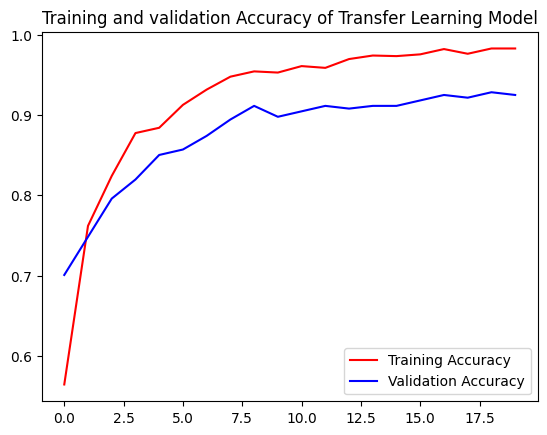

In [ ]:
acc = hist.history['accuracy']
loss = hist.history['loss']
val_accuracy = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
epochs = range(0, len(loss))

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title("Training and validation Loss".format())
plt.legend()
plt.savefig(res_data_dir + "Loss.png".format(model_name), dpi=100)
plt.close()

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b', label="Validation Accuracy")
plt.title("Training and validation Accuracy of Transfer Learning Model".format())
plt.legend()
plt.savefig(res_data_dir + "Accuracy.png".format(model_name), dpi=100)

avg_train_acc = np.mean(acc)
avg_train_loss = np.mean(loss)
avg_val_acc = np.mean(val_accuracy)
avg_val_loss = np.mean(val_loss)

with open(res_data_dir+'Train Results.txt', 'a') as files:
    files.write("Average Train Accuracy : {} \n".format(avg_train_acc))
    files.write("Average Train Loss : {} \n".format(avg_train_loss))
    files.write("Average Validation Accuracy : {} \n".format(avg_val_acc))
    files.write("Average Validation Loss : {} \n".format(avg_val_loss))


Transfer Learning did way better than two previous model. This might be beause of the noisy data that we analyze previously

# Testing

In [ ]:
def test_model(model, test_data):
    y_preds = model.predict(test_data, verbose=1)

    y_true = test_data.classes

    y_pred_classes = np.argmax(y_preds, axis=1)

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.show()

    report = classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys()))
    print(report)

    return y_preds, y_true

First Model

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


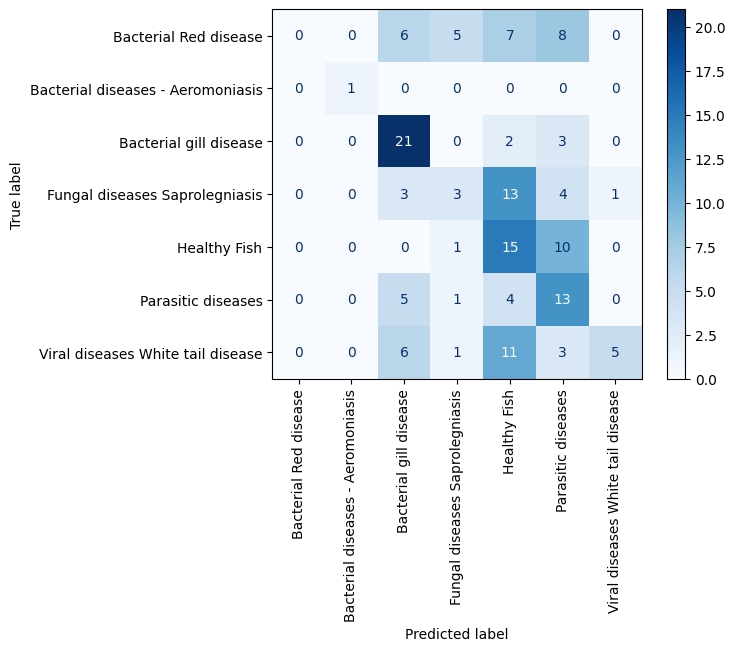

                                   precision    recall  f1-score   support

            Bacterial Red disease       0.00      0.00      0.00        26
Bacterial diseases - Aeromoniasis       1.00      1.00      1.00         1
           Bacterial gill disease       0.51      0.81      0.63        26
   Fungal diseases Saprolegniasis       0.27      0.12      0.17        24
                     Healthy Fish       0.29      0.58      0.38        26
               Parasitic diseases       0.32      0.57      0.41        23
Viral diseases White tail disease       0.83      0.19      0.31        26

                         accuracy                           0.38       152
                        macro avg       0.46      0.47      0.41       152
                     weighted avg       0.38      0.38      0.32       152



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_pred_1,y = test_model(modelSoal,test_it)

Analyze :
1. Accuracy : 38% -> The model hasnt found a good pattern yet. The model is still guessing for this multiclass dataset
2. F1 : 0.32 (Weighted Average) -> this mean that the model is not very good at predicting all classes correctly, balancing both precision and recall across the dataset
3. Recall : 0.38 (Weighted Average) -> The model only correctly identify about 38% of actual cases across all classes

These indicates that the model still unreliable

In [ ]:
modelSoal.evaluate(test_it)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3118 - loss: 1.8012


[1.6077831983566284, 0.3815789520740509]

Second Model(Fine Tuned)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step


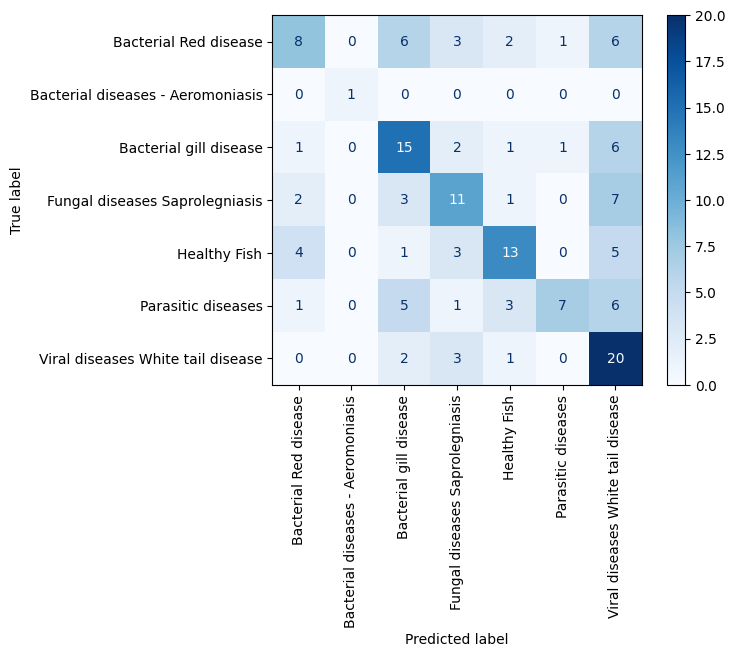

                                   precision    recall  f1-score   support

            Bacterial Red disease       0.50      0.31      0.38        26
Bacterial diseases - Aeromoniasis       1.00      1.00      1.00         1
           Bacterial gill disease       0.47      0.58      0.52        26
   Fungal diseases Saprolegniasis       0.48      0.46      0.47        24
                     Healthy Fish       0.62      0.50      0.55        26
               Parasitic diseases       0.78      0.30      0.44        23
Viral diseases White tail disease       0.40      0.77      0.53        26

                         accuracy                           0.49       152
                        macro avg       0.61      0.56      0.55       152
                     weighted avg       0.54      0.49      0.48       152



In [ ]:
y_pred_2,y = test_model(modelTuned,test_it)

Analyze :
1. Accuracy : 49% -> The model hasnt found a good pattern yet. The model is still guessing for this multiclass dataset
2. F1 : 0.48 (Weighted Average) -> this mean that the model is not very good at predicting all classes correctly, balancing both precision and recall across the dataset
3. Recall : 0.49 (Weighted Average) -> The model only correctly identify about 49% of actual cases across all classes

These indicates that the model still unreliable but a bit better than the first model

In [ ]:
modelTuned.evaluate(test_it)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.4348 - loss: 1.5281


[1.3949745893478394, 0.4934210479259491]

Third Model (Transfer Learning)

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step


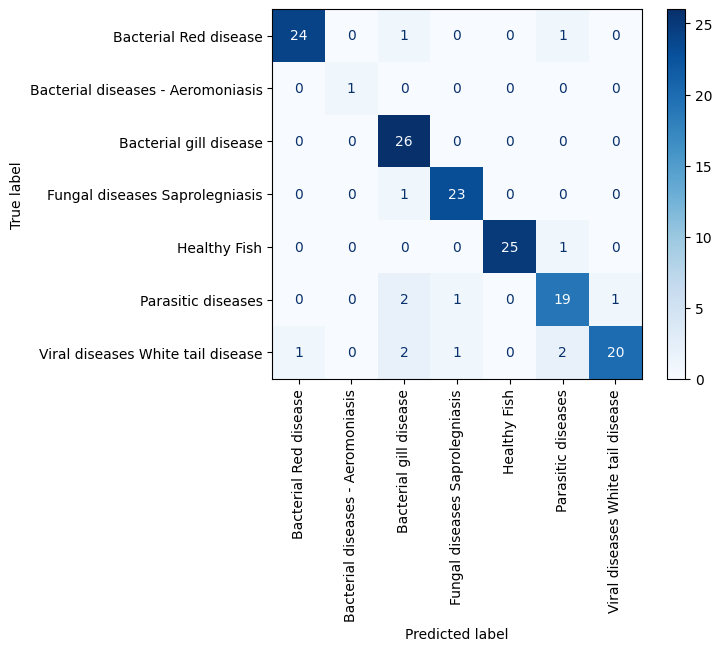

                                   precision    recall  f1-score   support

            Bacterial Red disease       0.96      0.92      0.94        26
Bacterial diseases - Aeromoniasis       1.00      1.00      1.00         1
           Bacterial gill disease       0.81      1.00      0.90        26
   Fungal diseases Saprolegniasis       0.92      0.96      0.94        24
                     Healthy Fish       1.00      0.96      0.98        26
               Parasitic diseases       0.83      0.83      0.83        23
Viral diseases White tail disease       0.95      0.77      0.85        26

                         accuracy                           0.91       152
                        macro avg       0.92      0.92      0.92       152
                     weighted avg       0.91      0.91      0.91       152



In [ ]:
y_pred_3,y = test_model(modelTwo,test_it)

Analyze :
1. Accuracy : 91% -> The model has found a very strong pattern and makes correct predictions for the majority of cases
2. F1 : 0.91 (Weighted Average) -> this mean that the model is now very good at predicting all classes correctly, balancing both precision and recall across the dataset
3. Recall : 0.91 (Weighted Average) -> The model now correctly identify about 91% of actual cases across all classes

These indicates that the transfer learning model is reliable

In [ ]:
modelTwo.evaluate(test_it)

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.9451 - loss: 0.1746


[0.22427800297737122, 0.9078947305679321]

# Conclusion

# Conclusion :
- In this case, the first model and fine tuned model underperformed with a low accuracy, f1 score, and recall, whether the pretrained model outperformed the other two model with a high accuracy, f1 score, and recall
- When dataset is limited, pretrained model is a better choice to achieve better performance rather than own model
- Besides the dataset being limited, some of the images also noisy and low quality making the model difficult to be trained from scratch. Therefore, transfer learning is a much better approach